# What species is that penguin?

## Group Contribution Statement

## Data Import and Cleaning

In [198]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations

In [199]:
# loads data
penguins = pd.read_csv("palmer_penguins.csv")

# selects for columns we are interested in
cols = ['Species', 'Island', 'Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Sex']
penguins = penguins[cols]

In [200]:
# helper functions

def clean_data(penguins_data):
    penguins_data = penguins_data.copy()
    # removes rows with missing data
    penguins_data = penguins_data.dropna()
    # removes row with where "Sex" = "."
    penguins_data = penguins_data.drop(penguins_data[penguins_data['Sex'] == '.'].index)
    # shortens Species name
    penguins_data["Species"] = penguins_data["Species"].str.split().str.get(0)

    return penguins_data

def encode_string_data(penguins_data, string_cols):
    penguins_data = penguins_data.copy()
    le = preprocessing.LabelEncoder()

    for col in string_cols:
        penguins_data[col] = le.fit_transform(penguins_data[col])

    return penguins_data

def prep_ml_data(penguins_data):
    penguins_data = penguins_data.copy()
    penguins_data = clean_data(penguins_data)
    penguins_data = encode_string_data(penguins_data, ["Island", "Sex", "Species"])

    X = penguins_data.drop(["Species"], axis = 1)
    y = penguins_data["Species"]

    return X, y

In [201]:
# prepares data for ml models

np.random.seed(42)
train, test = train_test_split(penguins, train_size=0.8, test_size=0.20)

X_train, y_train = prep_ml_data(train)
X_test, y_test = prep_ml_data(test)

## Exploratory Analysis

### Figure #3:

In [202]:
# clean data for exploratory analysis
penguins = clean_data(penguins)

[Text(0.5, 1.0, 'Torgerson'),
 Text(0.5, 28.999999999999993, 'Mean Culmen Length (mm)')]

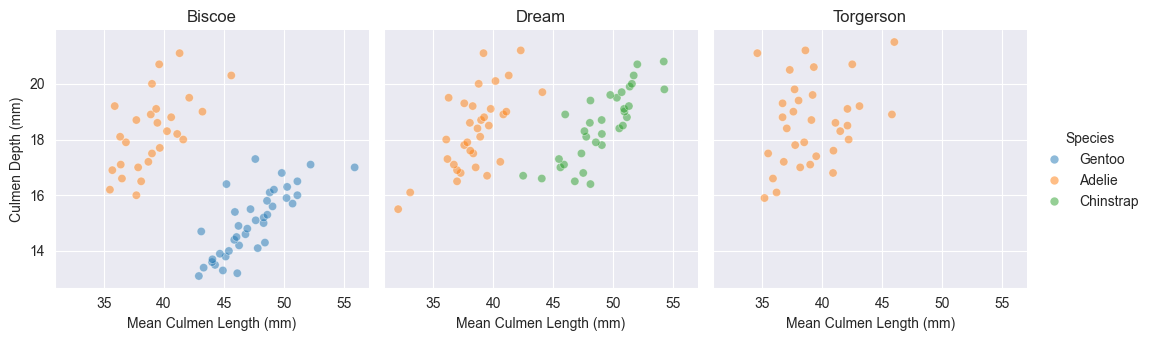

In [203]:
grouped = penguins.groupby(["Culmen Depth (mm)", "Species", "Island"])[["Culmen Length (mm)"]].mean().reset_index()

fig = sns.relplot(data=grouped,
                  y="Culmen Depth (mm)",
                  x="Culmen Length (mm)",
                  hue="Species",
                  col="Island",
                  height=3.5,
                  alpha=0.5)

fig.axes[0][0].set(title="Dream",
                   ylabel="Culmen Depth (mm)",
                   xlabel="Mean Culmen Length (mm)")
fig.axes[0][1].set(title="Biscoe",
                   xlabel="Mean Culmen Length (mm)")
fig.axes[0][2].set(title="Torgerson",
                   xlabel="Mean Culmen Length (mm)")

indicates that body mass, culmen length, and island might be good features

## Feature Selection

In [204]:
# automated feature selection, abstracted for different models
def select_features(model, training_data):
    def test_columns(cols):
        model.fit(X_train[cols], y_train)
        return cross_val_score(model, X_train, y_train, cv = 5).mean()

    # gets all combinations of 3 features
    col_combos = [list(cols) for cols in list(combinations(training_data.columns.tolist(), 3))]

    highest_score = -1
    best_cols = []
    for cols in col_combos:
        new_score = test_columns(cols)
        if new_score > highest_score:
            best_cols = cols
            highest_score = new_score

    return best_cols

## Modeling

### Model #3: Random Forest Classifier

In [205]:
# cross validation to find best max_depth parameter
score = []
depths = [i for i in range(1, 30)]
best_depth = -1
best_score = -1
for depth in depths:
    rf = RandomForestClassifier(max_depth=depth)
    curr_score = cross_val_score(rf, X_train, y_train, cv = 5).mean()
    curr_score = curr_score.mean()
    if curr_score > best_score:
        best_score = curr_score
        best_depth = depth
    score.append(curr_score)

In [206]:
# trains model on best features and best max_depth
RF = RandomForestClassifier(max_depth=best_depth)
RF_cols = select_features(RF, X_train)
RF.fit(X_test[RF_cols], y_test)

[]
[['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex'], ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island'], ['Culmen Length (mm)', 'Flipper Length (mm)', 'Sex'], ['Culmen Length (mm)', 'Flipper Length (mm)', 'Island'], ['Culmen Length (mm)', 'Body Mass (g)', 'Sex'], ['Culmen Length (mm)', 'Body Mass (g)', 'Island'], ['Culmen Depth (mm)', 'Flipper Length (mm)', 'Sex'], ['Culmen Depth (mm)', 'Flipper Length (mm)', 'Island'], ['Culmen Depth (mm)', 'Body Mass (g)', 'Sex'], ['Culmen Depth (mm)', 'Body Mass (g)', 'Island'], ['Flipper Length (mm)', 'Body Mass (g)', 'Sex'], ['Flipper Length (mm)', 'Body Mass (g)', 'Island']]


RandomForestClassifier(max_depth=12)

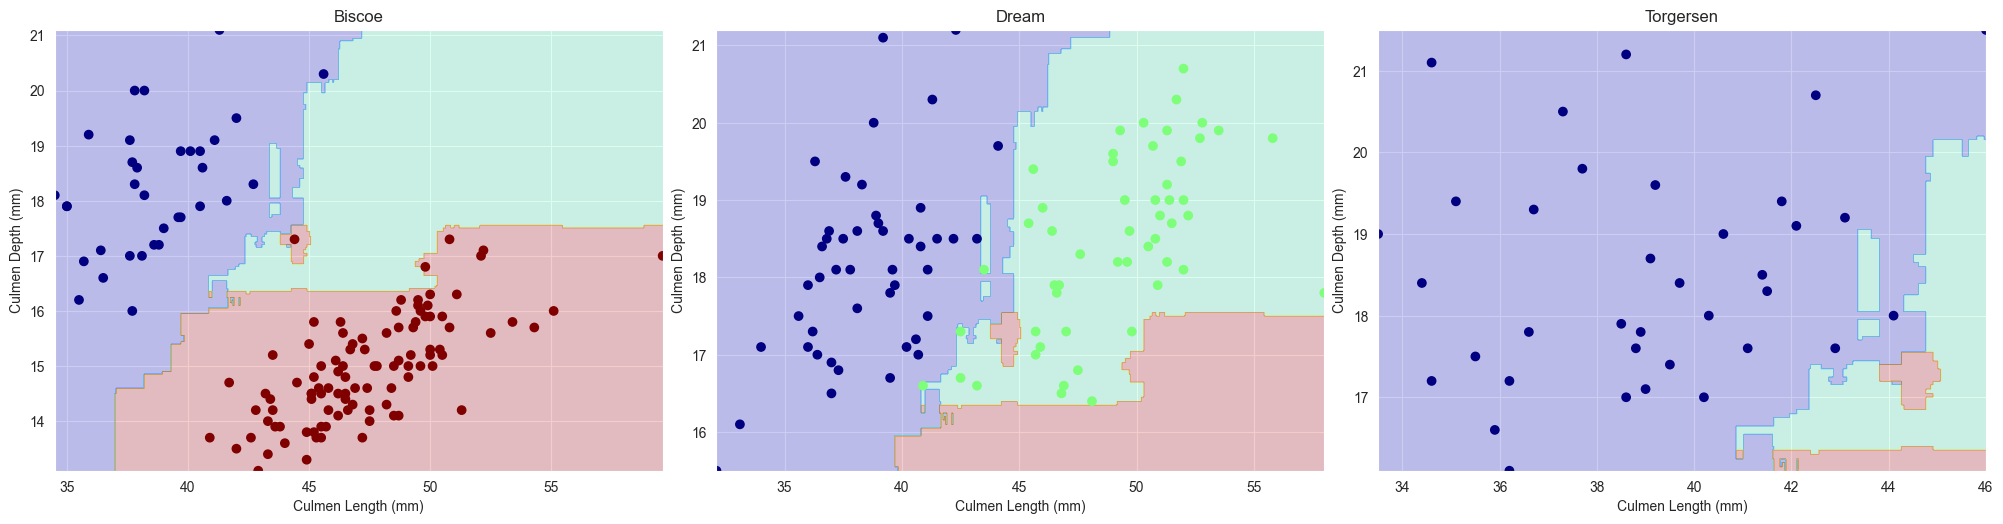

In [207]:
# eval on testing data
print(RF.score(X_test[RF_cols], y_test))

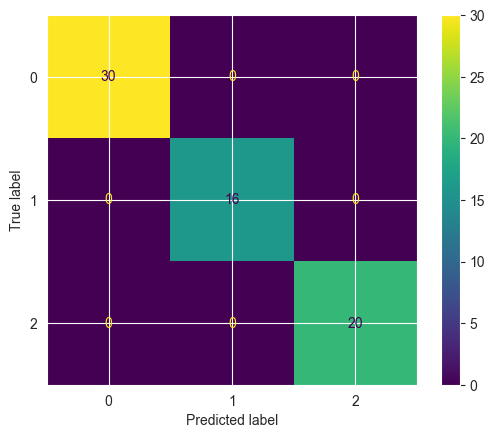

In [208]:
# confusion matrix
y_pred = RF.predict(X_test[RF_cols])
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [209]:
def plot_regions(c, X, y):
    """
    a simple function to plot decision regions for a classification model c
    if you use this function in your projects, you will need to modify how
    the prediction works in some important ways, AND you will need to ensure
    that the plots produced have a legend describing how the colors correspond
    to species. Additionally, you will need to include a better docstring than
    this one. =)
    """

    # for convenience, give names to the two
    # columns of the data
    x0 = X['Culmen Length (mm)']
    x1 = X['Culmen Depth (mm)']

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)

    # extract model predictions, using the
    # np.c_ attribute to join together the
    # two parts of the grid.
    # array.ravel() converts an multidimensional
    # array into a 1d array, and we use array.reshape()
    # to turn the resulting predictions p
    # back into 2d
    XX = xx.ravel()
    YY = yy.ravel()
    XY = pd.DataFrame({
        "Culmen Length (mm)" : XX,
        "Culmen Depth (mm)" : YY
    })

    p = c.predict(XY)
    p = p.reshape(xx.shape)

    # create the plot
    fig, ax = plt.subplots(1)

    # use contour plot to visualize the predictions
    ax.contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)

    # plot the data
    ax.scatter(x0, x1, c = y, cmap = "jet", vmin = 0, vmax = 2)
    ax.set(xlabel = "Culmen Length (mm)", ylabel = "Culmen Depth (mm)")

plot_regions(RF, X_test, y_test)

1.0


## Discussion